In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
import numpy as np
import pandas as pd
import os
import glob as gb
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

from skimage.io import imread, imshow
from skimage.transform import resize

In [4]:
TRAIN_PATH ='../Nails research paper/nails images/archive/images/'
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
train_ids = gb.glob(TRAIN_PATH+'*.jpg')
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)): 
    img = imread(id_)[:,:,:IMG_CHANNELS] 
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True) 
    X_train[n] = img

100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:03<00:00, 15.54it/s]


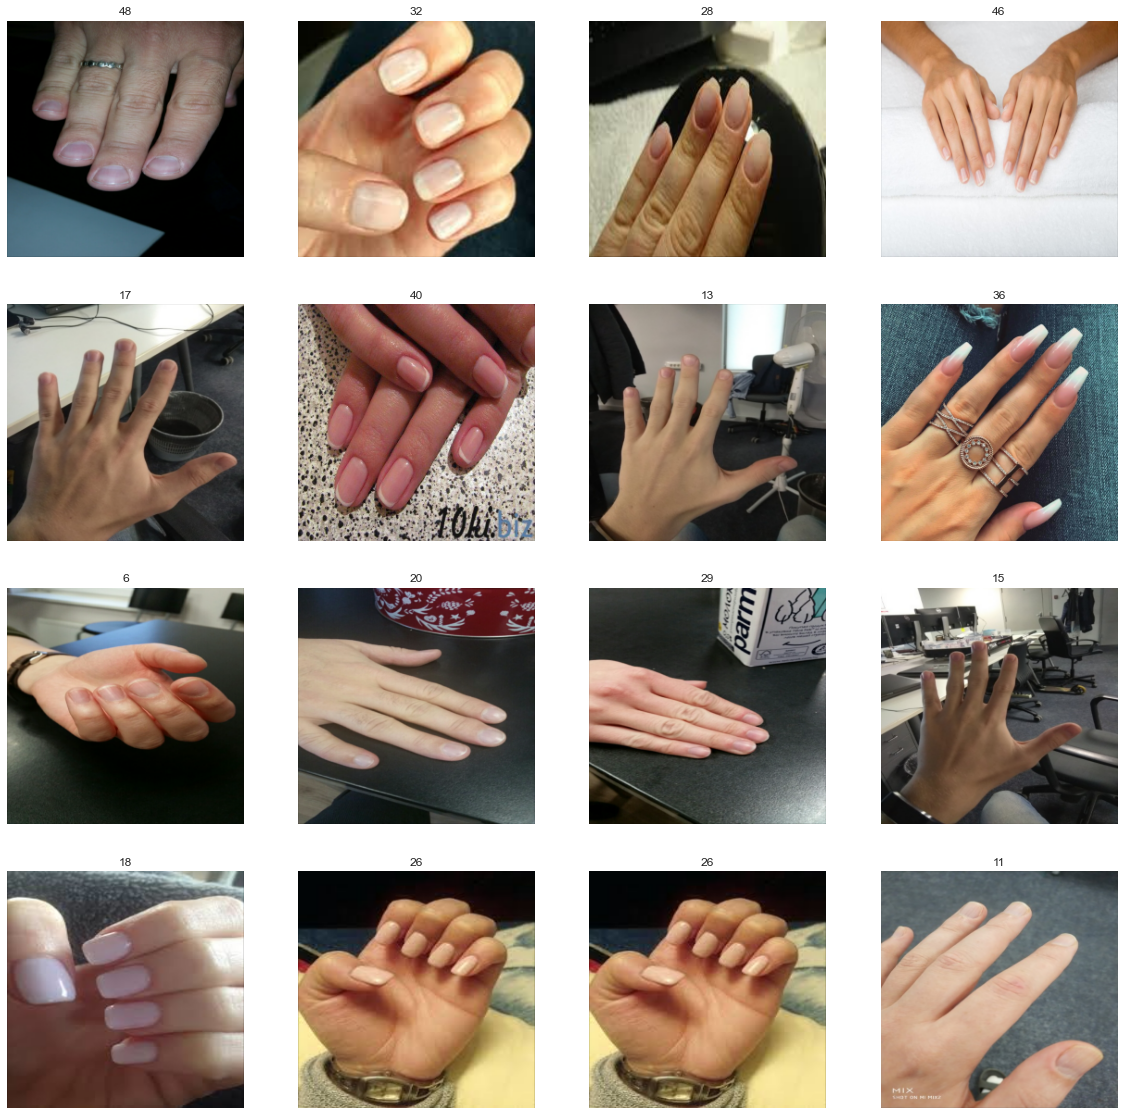

In [5]:
plt.figure(figsize=(20,20))
for n ,i in enumerate(list(np.random.randint(0,len(X_train),16))) :
    plt.subplot(4,4,n+1)
    plt.imshow(X_train[i])
    plt.axis('off')
    plt.title(i)

In [6]:
TRAIN_PATH ='../Nails research paper/nails images/archive/labels/'
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1
train_ids = gb.glob(TRAIN_PATH+'*.jpg')
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)): 
    mask = imread(id_)[:,:,:1] 
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True) 
    Y_train[n] = mask 

<ipython-input-6-478d0acf8d6f>:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 37.85it/s]


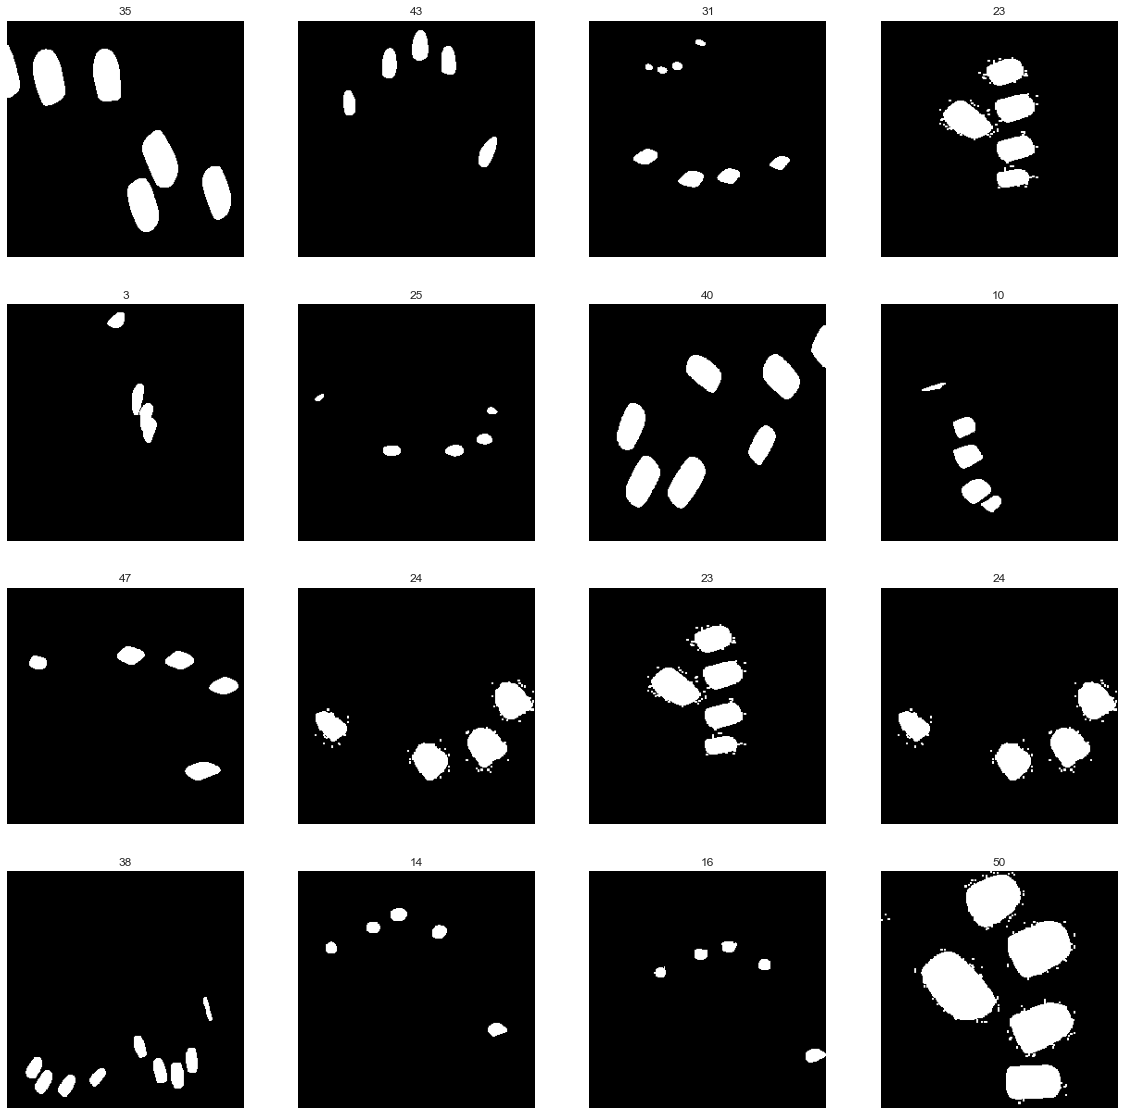

In [7]:
plt.figure(figsize=(20,20))
for n ,i in enumerate(list(np.random.randint(0,len(Y_train),16))) :
    plt.subplot(4,4,n+1)
    plt.imshow(Y_train[i],cmap='gray')
    plt.axis('off')
    plt.title(i)

In [8]:
import tensorflow
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Conv2D , MaxPooling2D ,concatenate ,Input ,Dropout ,Conv2DTranspose

In [9]:
def unet(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    #Contraction path
    
    
    c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    
    
    #Expansive path 
    
     
    u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c4)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c8)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

    model.summary()
    
    return model

In [10]:


model=unet(256,256,3)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 64  0           ['conv2d[0][0]']                 
                                )                                                             

In [11]:
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint

EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_accuracy',verbose=2,factor=0.5,min_lr=0.00001)
model_check=ModelCheckpoint('model.hdf5',monitor='val_loss',verbose=1,save_best_only=True)
callback=[EarlyStop , Reduce_LR,model_check]

In [12]:
history=model.fit(X_train,Y_train,validation_split=0.1,batch_size=8,steps_per_epoch=len(X_train)//8,epochs=50,
                 callbacks=callback,verbose=1,shuffle=True)

Epoch 1/50
6/6 [==============================] - ETA: 0s - loss: 74.3416 - accuracy: 0.6692 
Epoch 00001: val_loss improved from inf to 10.55818, saving model to model.hdf5
6/6 [==============================] - 74s 12s/step - loss: 74.3416 - accuracy: 0.6692 - val_loss: 10.5582 - val_accuracy: 0.9404 - lr: 0.0010
Epoch 2/50
6/6 [==============================] - ETA: 0s - loss: 6.8581 - accuracy: 0.9260 
Epoch 00002: val_loss improved from 10.55818 to 1.23201, saving model to model.hdf5
6/6 [==============================] - 70s 12s/step - loss: 6.8581 - accuracy: 0.9260 - val_loss: 1.2320 - val_accuracy: 0.8967 - lr: 0.0010
Epoch 3/50
6/6 [==============================] - ETA: 0s - loss: 2.5301 - accuracy: 0.8773 
Epoch 00003: val_loss did not improve from 1.23201
6/6 [==============================] - 77s 13s/step - loss: 2.5301 - accuracy: 0.8773 - val_loss: 1.6519 - val_accuracy: 0.9401 - lr: 0.0010
Epoch 4/50
6/6 [==============================] - ETA: 0s - loss: 1.5800 - accur

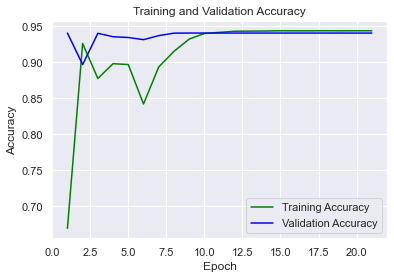

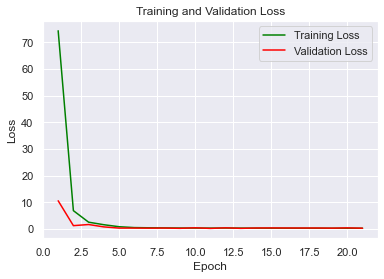

In [13]:
#plotting training values
import seaborn as sns
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='green', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [14]:
y_pred=model.predict(X_train)

In [15]:
y_pred_1=(y_pred > 0.3).astype(np.uint8)

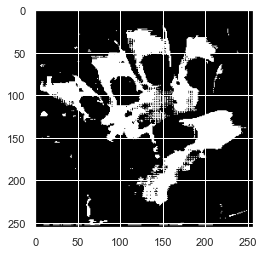

In [16]:
plt.imshow(y_pred_1[5],cmap='gray')
plt.show()